In [2]:
import pickle

with open("16000clean7dirty.pkl", "rb") as f:
    data = pickle.load(f)

print("DATA TYPE:", type(data))

if isinstance(data, dict):
    print("\nKEYS:")
    print(data.keys())
    
    print("\nDETAIL:")
    for k, v in data.items():
        try:
            print(k, type(v), v.shape)
        except:
            print(k, type(v))


DATA TYPE: <class 'dict'>

KEYS:
dict_keys(['clean', 'foggy', 'greenmarker', 'plastic', 'raindrop', 'hitwall', 'debris', 'dirtyrain'])

DETAIL:
clean <class 'numpy.ndarray'> (16000, 224, 224, 3)
foggy <class 'numpy.ndarray'> (1863, 224, 224, 3)
greenmarker <class 'numpy.ndarray'> (678, 224, 224, 3)
plastic <class 'numpy.ndarray'> (1922, 224, 224, 3)
raindrop <class 'numpy.ndarray'> (1663, 224, 224, 3)
hitwall <class 'numpy.ndarray'> (2000, 224, 224, 3)
debris <class 'numpy.ndarray'> (2000, 224, 224, 3)
dirtyrain <class 'numpy.ndarray'> (2000, 224, 224, 3)


clean: (16000, 224, 224, 3) uint8 0 255
rain : (1600, 224, 224, 3) uint8 11 255


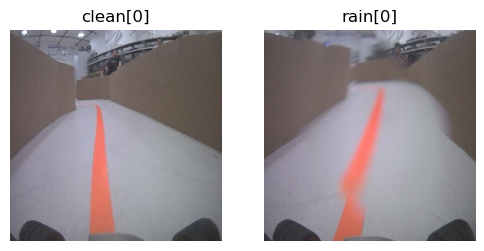

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

with open("16000clean7dirty.pkl", "rb") as f:
    data = pickle.load(f)

x_clean = data["clean"]
x_rain  = data["raindrop"][:1600]   # 先按学长要求取1600

print("clean:", x_clean.shape, x_clean.dtype, x_clean.min(), x_clean.max())
print("rain :", x_rain.shape,  x_rain.dtype,  x_rain.min(),  x_rain.max())

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.title("clean[0]"); plt.imshow(x_clean[0]); plt.axis("off")
plt.subplot(1,2,2); plt.title("rain[0]");  plt.imshow(x_rain[0]);  plt.axis("off")
plt.show()

In [8]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pickle

with open("16000clean7dirty.pkl", "rb") as f:
    data = pickle.load(f)

x_clean = data["clean"]                 # (16000,224,224,3) uint8
x_rain  = data["raindrop"][:1600]       # (1600,224,224,3) uint8

class MixDataset(Dataset):
    def __init__(self, x_clean, x_rain):
        self.x = np.concatenate([x_clean, x_rain], axis=0)  # uint8 NHWC

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        img = self.x[idx].astype(np.float32) / 255.0        # [0,1], HWC
        img = np.transpose(img, (2, 0, 1))                  # CHW
        img = torch.from_numpy(img)
        return img, img  # 自编码器：input=target

ds = MixDataset(x_clean, x_rain)
dl = DataLoader(ds, batch_size=64, shuffle=True, num_workers=0, pin_memory=False)

xb, yb = next(iter(dl))
print("batch:", xb.shape, xb.dtype, xb.min().item(), xb.max().item())

batch: torch.Size([64, 3, 224, 224]) torch.float32 0.019607843831181526 1.0


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CAE(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        # Encoder: 3 -> 16 -> 32 -> 64
        self.enc = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), nn.ReLU(),   # 224 -> 112
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(),  # 112 -> 56
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),  # 56 -> 28
        )
        self.fc1 = nn.Linear(64*28*28, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, 64*28*28)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),  # 28 -> 56
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1), nn.ReLU(),  # 56 -> 112
            nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1), nn.Sigmoid() # 112 -> 224
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.flatten(1)
        z = F.relu(self.fc1(h))
        return z

    def decode(self, z):
        h = F.relu(self.fc2(z))
        h = h.view(-1, 64, 28, 28)
        xrec = self.dec(h)
        return xrec

    def forward(self, x):
        z = self.encode(x)
        xrec = self.decode(z)
        return xrec, z

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CAE(latent_dim=256).to(device)

# quick sanity check
xb, _ = next(iter(dl))
xb = xb.to(device)
with torch.no_grad():
    xrec, z = model(xb)
print("x:", xb.shape, "xrec:", xrec.shape, "z:", z.shape)

x: torch.Size([64, 3, 224, 224]) xrec: torch.Size([64, 3, 224, 224]) z: torch.Size([64, 256])


In [13]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# 1) reference set：先用小一点 M（跑通后再加到1024）
M = 1024
all_idx = np.random.choice(len(ds), size=M, replace=False)

@torch.no_grad()
def build_href(model, ds, idx_list, device):
    model.eval()
    # 在CPU堆叠，再一次性搬到GPU（更稳）
    ref_imgs_cpu = torch.stack([ds[i][0] for i in idx_list], dim=0)
    ref_imgs = ref_imgs_cpu.to(device)
    _, zref = model(ref_imgs)          # (M,256)
    return zref.detach()               # 放GPU也行；先保持GPU

H_refer = build_href(model, ds, all_idx, device)
print("H_refer:", H_refer.shape)

# 2) optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
lambda_ref = 1.0

def latent_ref_loss(z, H_refer):
    z2 = (z**2).sum(dim=1, keepdim=True)          # (B,1)
    h2 = (H_refer**2).sum(dim=1).unsqueeze(0)     # (1,M)
    dist2 = z2 + h2 - 2.0 * (z @ H_refer.t())     # (B,M)
    nn_idx = dist2.argmin(dim=1)                  # (B,)
    z_near = H_refer[nn_idx]                      # (B,D)
    return F.mse_loss(z, z_near)

# 3) 训练：先跑 1 epoch 验证不会崩
model.train()
running = {"rec":0.0, "ref":0.0, "total":0.0}
steps = 0

for xb, _ in tqdm(dl, desc="train 1 epoch"):
    xb = xb.to(device, non_blocking=True)
    xrec, z = model(xb)

    Lrec = F.mse_loss(xrec, xb)
    Lref = latent_ref_loss(z, H_refer)

    if steps == 0:
        with torch.no_grad():
            # dist2: (B,M)
            z2 = (z**2).sum(dim=1, keepdim=True)
            h2 = (H_refer**2).sum(dim=1).unsqueeze(0)
            dist2 = z2 + h2 - 2.0*(z @ H_refer.t())
            nn_dist = dist2.min(dim=1).values.sqrt()  # 欧氏距离 (B,)
            print("nn_dist mean/min:", nn_dist.mean().item(), nn_dist.min().item())
            print("Lref first batch:", Lref.item())

    loss = Lrec + lambda_ref * Lref

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running["rec"] += Lrec.item()
    running["ref"] += Lref.item()
    running["total"] += loss.item()
    steps += 1

for k in running:
    running[k] /= steps

print("avg Lrec:", running["rec"], "avg Lref:", running["ref"], "avg total:", running["total"])

H_refer: torch.Size([1024, 256])


train 1 epoch:   1%|          | 3/275 [00:00<00:42,  6.41it/s]

nn_dist mean/min: 0.0 0.0
Lref first batch: 0.0


train 1 epoch: 100%|██████████| 275/275 [00:23<00:00, 11.90it/s]

avg Lrec: 0.008752561834725467 avg Lref: 0.0 avg total: 0.008752561834725467
